In [1]:
import pandas as pd
import pyarrow as pa
import pyarrow.parquet as pq
import numpy as np


In [2]:
price = pd.read_parquet('.\Dataset_sirius\imb_price.parquet', engine='pyarrow')
quantity = pd.read_parquet('.\Dataset_sirius\imb_quantity.parquet', engine='pyarrow')

In [3]:
price.isna().sum(), quantity.isna().sum()

(reference_date    0
 flow_date         0
 mtu               0
 value             0
 dtype: int64,
 reference_date    0
 flow_date         0
 mtu               0
 value             0
 dtype: int64)

In [4]:
price['value'].describe(), quantity['value'].describe()

(count    35040.000000
 mean       125.217314
 std         83.006971
 min          0.000000
 25%         68.340750
 50%         94.596000
 75%        196.322500
 max        512.999000
 Name: value, dtype: float64,
 count    35136.000000
 mean        34.231629
 std        144.281204
 min       -682.838000
 25%        -49.691750
 50%         25.842500
 75%        107.724750
 max       1541.638000
 Name: value, dtype: float64)

In [5]:
price['reference_date'] = pd.to_datetime(price['reference_date'])
quantity['reference_date'] = pd.to_datetime(quantity['reference_date'])

print(price['reference_date'].min(), price['reference_date'].max())
print(quantity['reference_date'].min(), quantity['reference_date'].max())

2024-08-31 22:00:00+00:00 2025-09-01 21:45:00+00:00
2024-08-31 22:00:00+00:00 2025-09-01 21:45:00+00:00


In [6]:
price['date'] = price['reference_date'].dt.date
price['date'].value_counts().sort_index()

date
2024-08-31     8
2024-09-01    96
2024-09-02    96
2024-09-03    96
2024-09-04    96
              ..
2025-08-28    96
2025-08-29    96
2025-08-30    96
2025-08-31    96
2025-09-01    88
Name: count, Length: 367, dtype: int64

In [7]:
price = price.rename(columns={'value': 'price'})
qty   = quantity.rename(columns={'value': 'quantity'})

df = qty[['reference_date', 'flow_date', 'mtu', 'quantity']].merge(
    price[['reference_date', 'price']],
    on='reference_date',
    how='left'
)

df['date']       = df['reference_date'].dt.date
df['year_month'] = df['reference_date'].dt.to_period('M').astype(str)
df['regime']     = np.where(df['quantity'] > 0, 'long', 'short')

df_obs = df[~df['price'].isna()].copy()

group_mmr = df_obs.groupby(
    ['year_month', 'mtu', 'regime']
)['price'].mean()

#if we don't have the specific mtu for that month and regime, we use the average for that month and regime
group_mr = df_obs.groupby(
    ['year_month', 'regime']
)['price'].mean()

# if we don't have the specific month, mtu and regime, we use the overall average for that regime
group_r = df_obs.groupby('regime')['price'].mean()


C:\Users\calan\AppData\Local\Temp\ipykernel_22184\1937568084.py:11: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df['year_month'] = df['reference_date'].dt.to_period('M').astype(str)


In [8]:
def impute_price(row):
    if not pd.isna(row['price']):
        return row['price']
    
    ym = row['year_month']
    mtu = row['mtu']
    reg = row['regime']
    
    # 1) Try with (year_month, mtu, regime)
    key_mmr = (ym, mtu, reg)
    if key_mmr in group_mmr.index:
        return group_mmr[key_mmr]
    
    # 2) Fallback: (year_month, regime)
    key_mr = (ym, reg)
    if key_mr in group_mr.index:
        return group_mr[key_mr]
    
    # 3) Fallback: only regime
    if reg in group_r.index:
        return group_r[reg]
    
    # 4) Ultimate fallback (should not happen): global average of observed price
    return df_obs['price'].mean()


df['price_filled'] = df.apply(impute_price, axis=1)

# Flag that indicates if the row was imputed
df['price_imputed'] = df['price'].isna().astype(int)

print("Check NaN after imputation:", df['price_filled'].isna().sum())

Check NaN after imputation: 0


## Note
We notice that the number of prices and quantities don't match by 96 rows (a day), even if the series start and end at the same dates.

Further analysis brought the conclusion that we don't have the values of the imbalance price of a whole day. 

We are filled the missing values of the price with the average of the month at that specific MTU conditioning on the fact that we are in deficit or surplus.


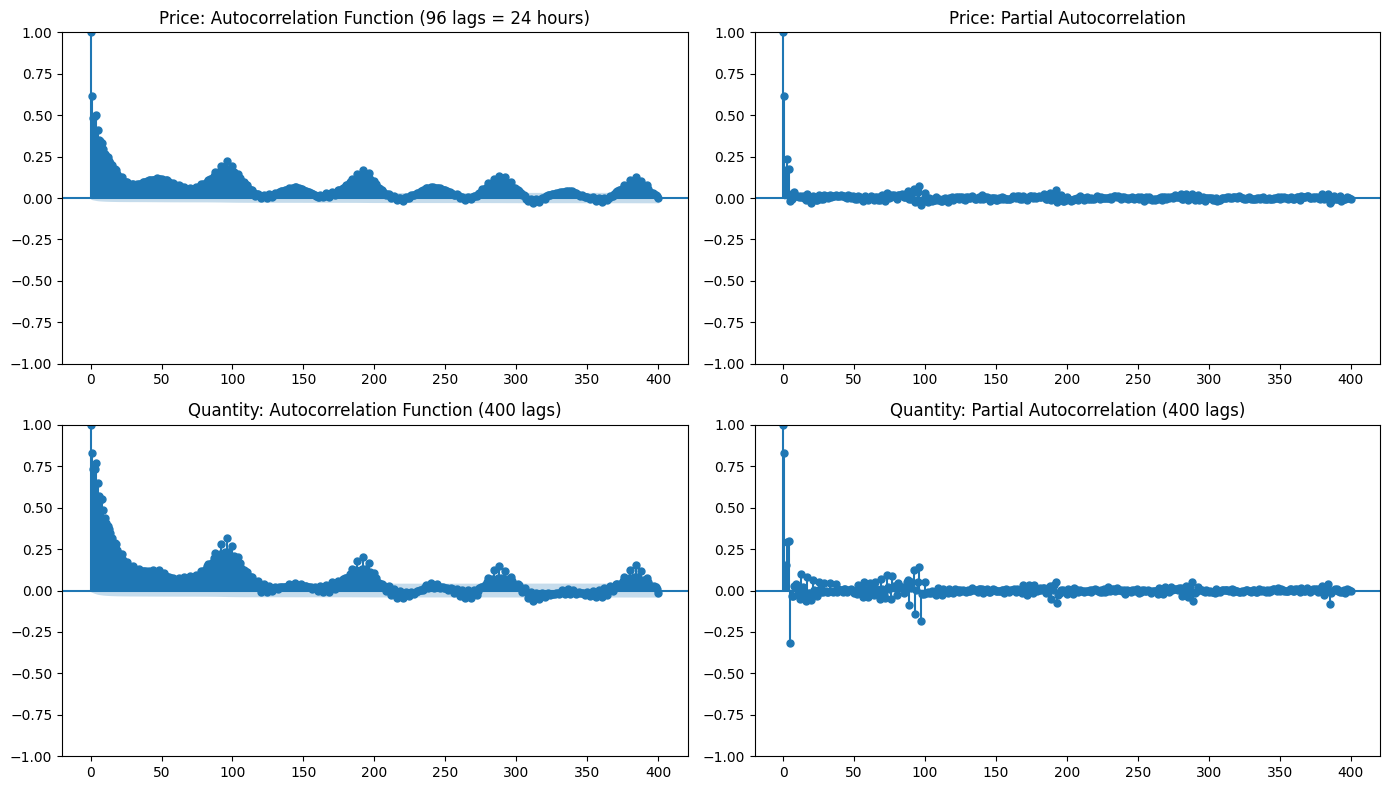

In [9]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, axes = plt.subplots(2, 2, figsize=(14, 8))

# ACF/PACF for price
plot_acf(df['price_filled'].dropna(), lags=400, ax=axes[0, 0], alpha=0.05)
axes[0, 0].set_title('Price: Autocorrelation Function (96 lags = 24 hours)')
plot_pacf(df['price_filled'].dropna(), lags=400, ax=axes[0, 1], alpha=0.05)
axes[0, 1].set_title('Price: Partial Autocorrelation')

# ACF/PACF for quantity
plot_acf(df['quantity'].dropna(), lags=400, ax=axes[1, 0], alpha=0.05 )
axes[1, 0].set_title('Quantity: Autocorrelation Function (400 lags)')
plot_pacf(df['quantity'].dropna(), lags=400, ax=axes[1, 1], alpha=0.05)
axes[1, 1].set_title('Quantity: Partial Autocorrelation (400 lags)')

plt.tight_layout()
plt.savefig('acf_pacf_analysis.png', dpi=150, bbox_inches='tight')
plt.show()


As we could expect our series ar non-stationary. In order to apply TimeSeries model we have to transform our data.

We cannot simply compute the returns as we don't have the day-ahead price, and computing returns of imbalance price is not a good idea since a good amount of or prices is exactly zero or close to zero.

We tried different ways of making the price stationary:
 y_t-y_{t-1}
 arcsinh(y_t), usually used in theory should reduce the variance and the spikes due to the jump from surplus/deficit regime
 y_t-y_{t-96}, should capture the day-by-day seasonality
 same differences for the transformed price


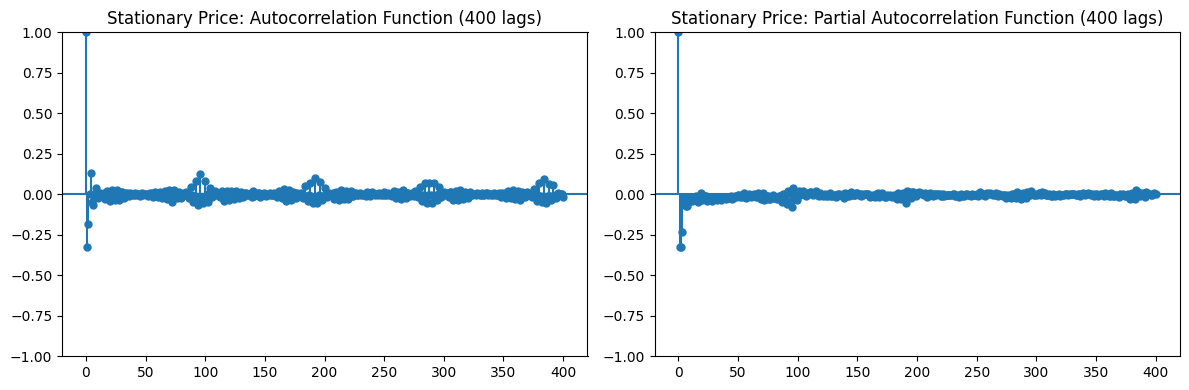

In [10]:
#We want to make the serie stationary
y = df['price_filled']
st_price = y.diff().dropna()
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
plot_acf(st_price, lags=400, ax=axes[0], alpha=0.05)
axes[0].set_title('Stationary Price: Autocorrelation Function (400 lags)')
plot_pacf(st_price, lags=400, ax=axes[1], alpha=0.05)
axes[1].set_title('Stationary Price: Partial Autocorrelation Function (400 lags)')
plt.tight_layout()


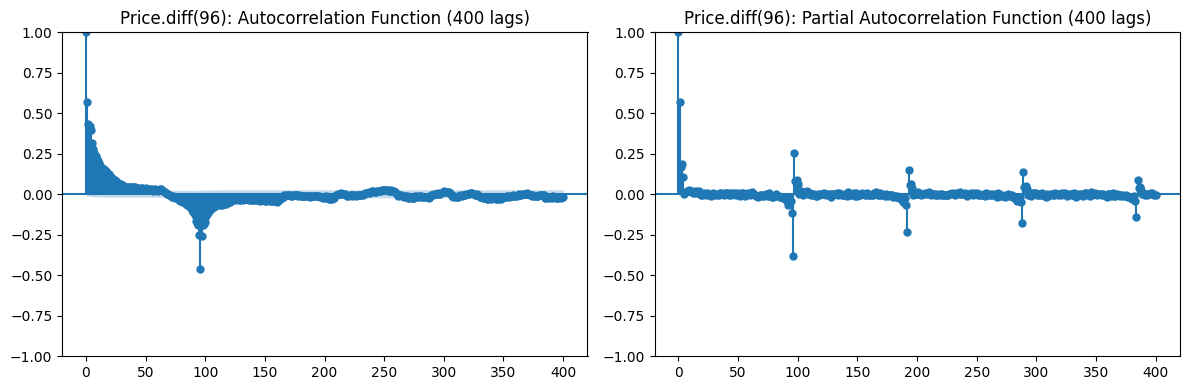

In [11]:
y_diff96 = y.diff(96).dropna()
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
plot_acf(y_diff96, lags=400, ax=axes[0], alpha=0.05)
axes[0].set_title('Price.diff(96): Autocorrelation Function (400 lags)')
plot_pacf(y_diff96, lags=400, ax=axes[1], alpha=0.05)
axes[1].set_title('Price.diff(96): Partial Autocorrelation Function (400 lags)')
plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'Transformed Price: Partial Autocorrelation Function (400 lags)')

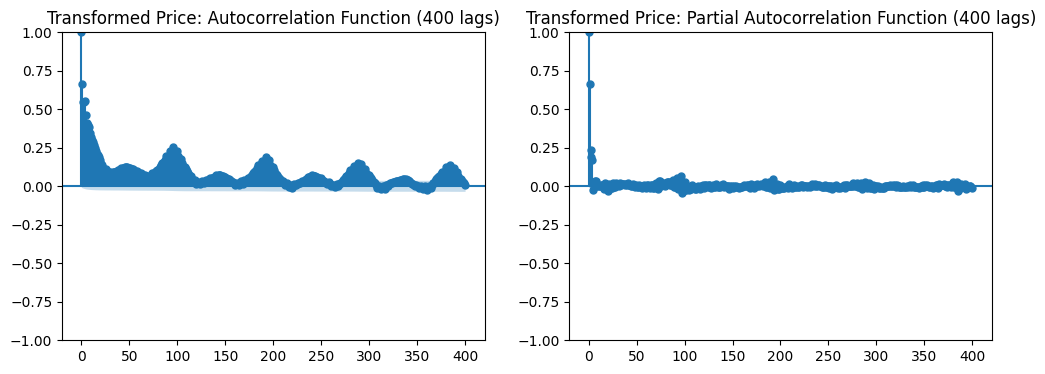

In [36]:
c = df['price_filled'].std()
price_transformed = np.arcsinh(df['price_filled'] / c)/c

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
plot_acf(price_transformed, lags=400, ax=axes[0], alpha=0.05)
axes[0].set_title('Transformed Price: Autocorrelation Function (400 lags)')
plot_pacf(price_transformed, lags=400, ax=axes[1], alpha=0.05)
axes[1].set_title('Transformed Price: Partial Autocorrelation Function (400 lags)')

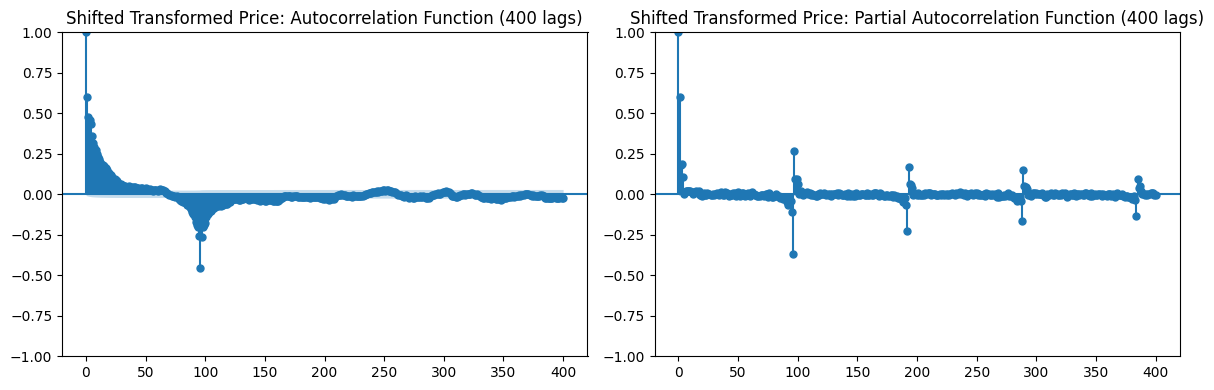

In [37]:
shifted_price = price_transformed - price_transformed.shift(96)

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
plot_acf(shifted_price.dropna(), lags=400, ax=axes[0], alpha=0.05)
axes[0].set_title('Shifted Transformed Price: Autocorrelation Function (400 lags)')
plot_pacf(shifted_price.dropna(), lags=400, ax=axes[1], alpha=0.05)
axes[1].set_title('Shifted Transformed Price: Partial Autocorrelation Function (400 lags)')
plt.tight_layout()
plt.show()



Already from the graphs we can exclude the transformed price and the trasformed price.

We proceed with two test to asses whether the TS are stationary and distributed across a constant mean.

In [14]:
from statsmodels.tsa.stattools import adfuller, kpss

def stationarity_tests(x, name="series"):
    x = pd.Series(x).dropna()
    print(f"\n=== {name} ===")
    
    # ADF test (H0: unit root → NON stazionaria)
    adf_res = adfuller(x, autolag='AIC')
    print("ADF:")
    print(f"  p-value        = {adf_res[1]:.3f}")
    
    # KPSS test (H0: stazionaria)
    kpss_res = kpss(x, regression='c', nlags='auto')
    print("KPSS:")
    print(f"  p-value        = {kpss_res[1]:.3f}")


In [15]:

stationarity_tests(st_price,          "price.diff()")
stationarity_tests(price_transformed,        "asinh(price)")
stationarity_tests(y_diff96,     "price.diff(96)")
stationarity_tests(shifted_price,    "asinh(price).diff(96)")



=== price.diff() ===
ADF:
  p-value        = 0.000
KPSS:
  p-value        = 0.100

=== asinh(price) ===


C:\Users\calan\AppData\Local\Temp\ipykernel_22184\593513805.py:13: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_res = kpss(x, regression='c', nlags='auto')


ADF:
  p-value        = 0.000


C:\Users\calan\AppData\Local\Temp\ipykernel_22184\593513805.py:13: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_res = kpss(x, regression='c', nlags='auto')


KPSS:
  p-value        = 0.010

=== price.diff(96) ===
ADF:
  p-value        = 0.000
KPSS:
  p-value        = 0.100

=== asinh(price).diff(96) ===


C:\Users\calan\AppData\Local\Temp\ipykernel_22184\593513805.py:13: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_res = kpss(x, regression='c', nlags='auto')


ADF:
  p-value        = 0.000
KPSS:
  p-value        = 0.100


C:\Users\calan\AppData\Local\Temp\ipykernel_22184\593513805.py:13: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_res = kpss(x, regression='c', nlags='auto')


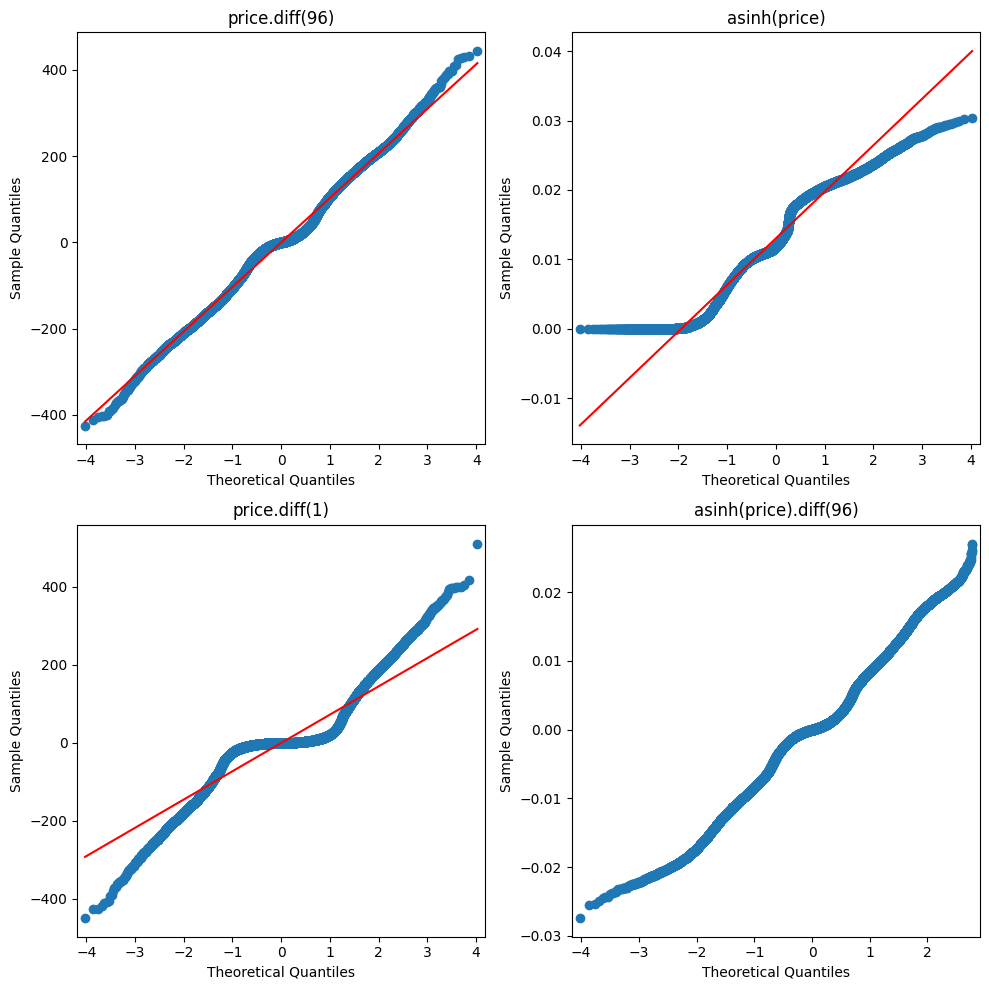

In [38]:
from statsmodels.graphics.gofplots import qqplot
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(10, 10))
qqplot(y_diff96, line='s', ax=axes[0, 0])
axes[0, 0].set_title("price.diff(96)")
qqplot(price_transformed, line='s', ax=axes[0, 1])
axes[0, 1].set_title("asinh(price)")
qqplot(st_price, line='s', ax=axes[1, 0])
axes[1, 0].set_title("price.diff(1)")
qqplot(shifted_price, line='s', ax=axes[1, 1])
axes[1, 1].set_title("asinh(price).diff(96)")
plt.tight_layout()
plt.show()

From the QQ-Plot and the two test above the price (both transforned and not) shifted by 96 appears almost stationary and almost normally distributed.

We can proceed with our TimeSeries forecasting.

We are going to use an ARIMA and the a SARIMA to capture the seasonality. Let's analyze again the PACF and ACF with less lags to find p and q 

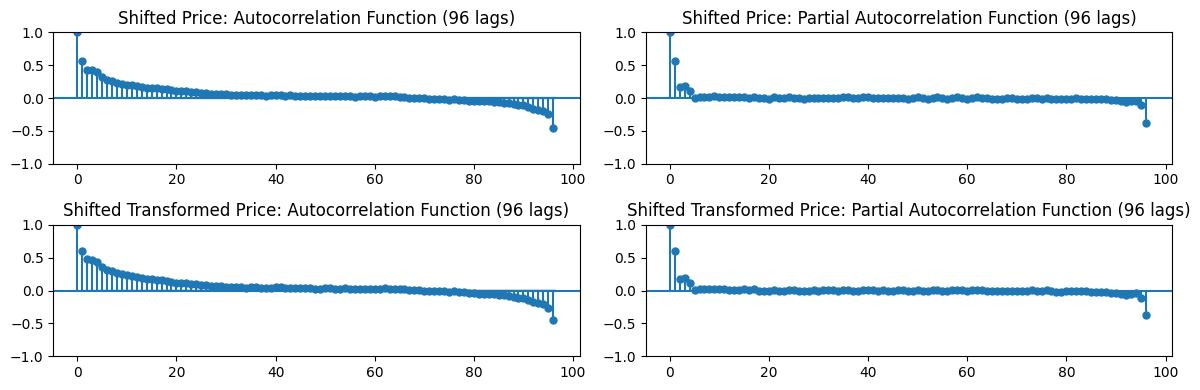

In [39]:
fig, axes = plt.subplots(2, 2, figsize=(12, 4))
plot_acf(y_diff96.dropna(), lags=96, ax=axes[0, 0], alpha=0.05)
axes[0, 0].set_title('Shifted Price: Autocorrelation Function (96 lags)')
plot_pacf(y_diff96.dropna(), lags=96, ax=axes[0, 1], alpha=0.05)
axes[0, 1].set_title('Shifted Price: Partial Autocorrelation Function (96 lags)')
plot_acf(shifted_price.dropna(), lags=96, ax=axes[1, 0], alpha=0.05)
axes[1, 0].set_title('Shifted Transformed Price: Autocorrelation Function (96 lags)')
plot_pacf(shifted_price.dropna(), lags=96, ax=axes[1, 1], alpha=0.05)
axes[1, 1].set_title('Shifted Transformed Price: Partial Autocorrelation Function (96 lags)')
plt.tight_layout()
plt.show()

From the plots (only 96 lags) we deduce that our SARIMA will have d=0, D=1 and we are going to perform a CV to find the best set of parameters

In [35]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

order = (1, 1, 1)
seas  = (0, 0, 1, 96)

y_sub = price_transformed.iloc[-96*30:]  


model = SARIMAX(
    y_sub,
    order=order,
    seasonal_order=seas,
    simple_differencing=True,
    trend='n',
)

res = model.fit(disp=False, maxiter=30)

In [40]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                     D.price_filled   No. Observations:                 2879
Model:             SARIMAX(1, 0, 1)x(0, 0, 1, 96)   Log Likelihood               -1011.450
Date:                            dom, 30 nov 2025   AIC                           2030.901
Time:                                    11:06:26   BIC                           2054.762
Sample:                                         0   HQIC                          2039.501
                                           - 2879                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3306      0.019     17.159      0.000       0.293       0.368
ma.L1         -0.7793      0.015    -53.250      0.000      -0.808      -0.751
ma.S.L96       0.0826      0.017      4.954      0.000       0.050       0.115
sigma2         0.1182      0.002     71.375      0.000       0.115       0.121
===================================================================================
Ljung-Box (L1) (Q):                   0.57   Jarque-Bera (JB):              4635.28
Prob(Q):                              0.45   Prob(JB):                         0.00
Heteroskedasticity (H):               1.16   Skew:                             0.81
Prob(H) (two-sided):                  0.02   Kurtosis:                         9.00
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

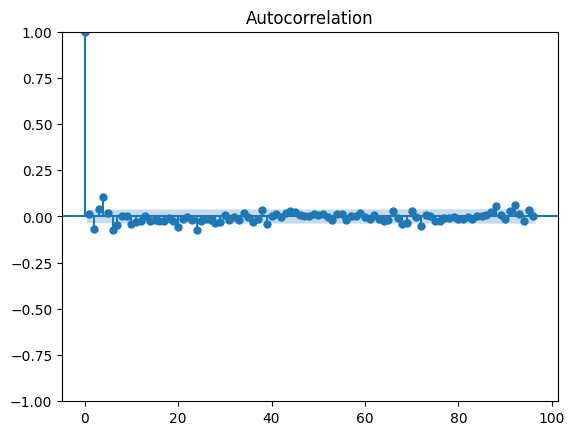

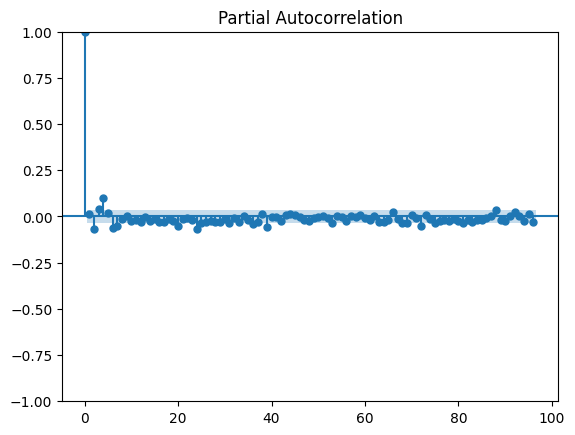

In [34]:
resid = res.resid.dropna()
plot_acf(resid, lags=96); plt.show()
plot_pacf(resid, lags=96, method='ywm'); plt.show()


In [19]:

def build_all_features(
    price: pd.DataFrame,
    quantity: pd.DataFrame,
    lag_steps=(1, 2, 4, 8, 12, 24),           # Empirically selected via ACF/PACF analysis
    roll_windows=(4, 8, 16, 32, 64),          # Rolling windows: 15min to 4 hours
    long_share_windows=(8, 16, 32, 48),       # Regime memory: 2 to 12 hours (justified by quantity ACF)
) -> pd.DataFrame:
    """
    Build engineered features for multi-step imbalance price and regime forecasting.
    
    All features are constructed using only information available at forecast time (no lookahead).
    Features are designed to capture: short-term momentum (lags), local volatility (rolling stats),
    calendar seasonality, intraday patterns, regime persistence, and price-quantity interactions.

    Parameters
    ----------
    price : pd.DataFrame
        DataFrame with columns ["flow_date", "mtu", "reference_date", "value"].
        - value: imbalance price in EUR/MWh
        - reference_date: UTC timestamp (enforces strict time ordering)
    quantity : pd.DataFrame
        DataFrame with identical structure as price.
        - value: imbalance quantity in MWh (positive = long/surplus, negative = short/deficit)
    lag_steps : tuple of int, optional
        Lags (in MTUs, 15-minute intervals) for autoregressive features.
        Default: (1, 2, 4, 8, 12, 24) → captures 15 minutes to 6 hours of history.
        Rationale: ACF analysis shows lag-1 dominates (~0.65 for price, ~0.80 for quantity),
        with meaningful but decaying correlation up to lag-24. Lags beyond 24 contribute
        diminishing signal and risk overfitting; PACF confirms AR(1) dominance.
    roll_windows : tuple of int, optional
        Rolling window sizes (MTUs) for mean/std computation.
        Default: (4, 8, 16, 32, 64) → 1 hour to 4.3 hours.
        These complement lags by capturing local volatility and smoothed trends,
        reducing multicollinearity risk from stacking many lagged features.
    long_share_windows : tuple of int, optional
        Windows (MTUs) for computing historical proportion of long regimes.
        Default: (8, 16, 32, 48) → 2 to 12 hours.
        Quantity ACF shows strong persistence; these capture regime persistence effects.

    Returns
    -------
    pd.DataFrame
        Feature matrix sorted by reference_date with ~80–100 features:
        - Base series: price, quantity, is_long (binary regime indicator)
        - Lagged features: price, quantity, is_long at selected lags
        - Rolling statistics: mean and std for price and quantity
        - Calendar features: day-of-week, weekend flag, month, hour_of_day, peak hours
        - Intraday seasonality: sine/cosine encoding (respects 24-hour cyclicity)
        - Regime memory: long_share (historical proportion long), long_streak, short_streak
        - Momentum: 1-step and multi-step price/quantity changes
        - Interactions: price × quantity decomposed by regime (long vs. short)
        
    Notes
    -----
    - All rolling operations use min_periods=1 to avoid NaN at series start, but rows with
      insufficient history should be dropped by caller before modeling (see data validation cell).
    - No external data (weather, load forecasts, day-ahead prices) is used, per project constraints.
    - Time ordering (reference_date) is strictly maintained; no sorting by other columns.
    """
    
    # =========================================================================
    # 1) MERGE BASE SERIES & DEFINE REGIME
    # =========================================================================
    # Rename 'value' columns to descriptive names and merge on time identifiers
    price_df = price.rename(columns={"value": "price"})
    qty_df = quantity.rename(columns={"value": "quantity"})

    df = (
        price_df.merge(
            qty_df,
            on=["flow_date", "mtu", "reference_date"],
            how="inner",
            validate="one_to_one",
        )
        .sort_values("reference_date")
        .reset_index(drop=True)
    )

    # Binary regime: 1 = long (surplus), 0 = short (deficit)
    # This is the target for probability forecasts (Task 2)
    df["is_long"] = (df["quantity"] > 0).astype(int)

    # Ensure flow_date is datetime (required for calendar features)
    if not np.issubdtype(df["flow_date"].dtype, np.datetime64):
        df["flow_date"] = pd.to_datetime(df["flow_date"])

    # =========================================================================
    # 2) AUTOREGRESSIVE FEATURES (Lags)
    # =========================================================================
    # Lag features capture short-term persistence. ACF analysis shows:
    # - Price lag-1 ACF ≈ 0.65 (strong immediate dependence)
    # - Quantity lag-1 ACF ≈ 0.80 (very strong; imbalances persist longer)
    # - PACF flattens after lag-1; subsequent lags refine but risk multicollinearity
    
    for l in lag_steps:
        df[f"price_lag_{l}"] = df["price"].shift(l)
        df[f"quantity_lag_{l}"] = df["quantity"].shift(l)
        df[f"is_long_lag_{l}"] = df["is_long"].shift(l)

    # =========================================================================
    # 3) ROLLING STATISTICS
    # =========================================================================
    # Rolling mean/std capture local trends and volatility without multicollinearity
    # issues inherent to many lagged features. Window sizes chosen to complement lags:
    # - 4 MTUs (1 hour): very local volatility
    # - 8 MTUs (2 hours): short-term trend
    # - 16 MTUs (4 hours): medium-term smoothing
    # - 32 MTUs (8 hours): longer-term baseline
    # - 64 MTUs (4.3 hours): captures half-day trends
    
    for w in roll_windows:
        df[f"price_roll_mean_{w}"] = df["price"].rolling(w, min_periods=1).mean()
        df[f"price_roll_std_{w}"] = df["price"].rolling(w, min_periods=1).std()

        df[f"quantity_roll_mean_{w}"] = df["quantity"].rolling(w, min_periods=1).mean()
        df[f"quantity_roll_std_{w}"] = df["quantity"].rolling(w, min_periods=1).std()

    # =========================================================================
    # 4) CALENDAR & TEMPORAL FEATURES
    # =========================================================================
    # No external data used; all features derived from timestamps and MTU index
    
    # Day-of-week and weekend flag
    df["dow"] = df["flow_date"].dt.weekday          # 0=Monday, 6=Sunday
    df["is_weekend"] = (df["dow"] >= 5).astype(int) # 1 if Sat/Sun
    df["month"] = df["flow_date"].dt.month           # 1-12

    # Hour of day: MTU ranges 1-96 per day; 4 MTUs = 1 hour
    df["hour_of_day"] = (df["mtu"] // 4).astype(int)  # 0-23

    # Peak hours: 08:00–20:00 (typical high-demand window in EU grids)
    # Imbalance prices often spike during peak demand and evening ramps
    df["is_peak_hour"] = ((df["hour_of_day"] >= 8) & (df["hour_of_day"] < 20)).astype(int)

    # =========================================================================
    # 5) INTRADAY SEASONALITY (Cyclical Encoding)
    # =========================================================================
    # Sine/cosine encoding respects the circular nature of time-of-day:
    # - Avoids artificial boundary discontinuity between MTU 95 (23:45) and MTU 0 (00:00)
    # - Allows linear models to learn smooth, periodic patterns
    # - Neural networks benefit from this representation as well
    
    df["mtu_sin"] = np.sin(2 * np.pi * df["mtu"] / 96.0)
    df["mtu_cos"] = np.cos(2 * np.pi * df["mtu"] / 96.0)

    # =========================================================================
    # 6) SEASONAL FEATURES
    # =========================================================================
    # Seasons affect generation mix (e.g., solar peaks in summer) and demand patterns
    
    month = df["month"]
    season = pd.Series(index=df.index, dtype="object")

    season[(month == 12) | (month <= 2)] = "winter"   # Dec, Jan, Feb
    season[(month >= 3) & (month <= 5)] = "spring"    # Mar, Apr, May
    season[(month >= 6) & (month <= 8)] = "summer"    # Jun, Jul, Aug
    season[(month >= 9) & (month <= 11)] = "autumn"   # Sep, Oct, Nov

    df["season"] = season.astype("category")

    # =========================================================================
    # 7) DAYLIGHT INDICATOR (Heuristic Proxy for Solar Generation)
    # =========================================================================
    # Note: This is NOT actual weather data.
    # Instead, it's a calendar-based heuristic that correlates with typical solar
    # generation windows in Central Europe. Trees/ensemble models will learn that
    # morning/midday imbalances during daylight hours often signal solar generation.
    # This heuristic is validated empirically by observing correlations in data.
    
    df["is_sun"] = 0

    # Summer: longer days, roughly 06:00–21:00
    mask_summer = df["season"] == "summer"
    df.loc[mask_summer & (df["hour_of_day"] >= 6) & (df["hour_of_day"] < 21), "is_sun"] = 1

    # Winter: shorter days, roughly 08:00–17:00
    mask_winter = df["season"] == "winter"
    df.loc[mask_winter & (df["hour_of_day"] >= 8) & (df["hour_of_day"] < 17), "is_sun"] = 1

    # Spring/Autumn: intermediate, roughly 07:00–20:00
    mask_spring_autumn = df["season"].isin(["spring", "autumn"])
    df.loc[
        mask_spring_autumn
        & (df["hour_of_day"] >= 7)
        & (df["hour_of_day"] < 20),
        "is_sun"
    ] = 1

    df["is_sun"] = df["is_sun"].astype(int)

    # =========================================================================
    # 8) GENERATION RAMP FEATURES
    # =========================================================================
    # Morning ramp (typically 07:00–09:00): Solar generation increases rapidly
    # Evening ramp (typically 18:00–20:00): Solar generation drops; demand peaks
    # These features help capture transition periods where imbalances are volatile
    
    df["is_morning_ramp"] = ((df["hour_of_day"] >= 7) & (df["hour_of_day"] < 9)).astype(int)
    df["is_evening_ramp"] = ((df["hour_of_day"] >= 18) & (df["hour_of_day"] < 20)).astype(int)

    # =========================================================================
    # 9) MOMENTUM FEATURES
    # =========================================================================
    # Capture first and higher-order differences to detect trend changes
    
    # 1-step quantity change: signals regime transitions (long → short or vice versa)
    df["dq_1"] = df["quantity"] - df["quantity_lag_1"]
    df["abs_dq_1"] = df["dq_1"].abs()  # Absolute change; magnitude matters regardless of sign

    # Multi-step price changes (1 hour and 24 hours back)
    # Detects momentum and mean reversion patterns
    for lag in (4, 96):
        col = f"price_lag_{lag}"
        if col in df.columns:
            df[f"dp_{lag}"] = df["price"] - df[col]

    # =========================================================================
    # 10) REGIME MEMORY FEATURES
    # =========================================================================
    # Capture persistence of long/short regimes. Quantity ACF shows strong daily
    # cycles (peaks every ~96 lags), meaning regimes repeat with daily frequency.
    
    # Historical proportion of long regime over sliding windows
    # Shift by 1 to ensure no lookahead: use only *past* regime values to predict future
    for window in long_share_windows:
        df[f"long_share_{window}"] = (
            df["is_long"].shift(1)
            .rolling(window, min_periods=1)
            .mean()
        )

    # Streak lengths: consecutive steps of being long or short
    # Long streaks → high probability next step also long; useful for regime persistence
    long_streak = np.zeros(len(df), dtype=int)
    short_streak = np.zeros(len(df), dtype=int)

    prev_long = 0
    prev_short = 0

    for i, val in enumerate(df["is_long"].values):
        if val == 1:
            prev_long += 1
            prev_short = 0
        else:
            prev_short += 1
            prev_long = 0
        long_streak[i] = prev_long
        short_streak[i] = prev_short

    df["long_streak"] = long_streak
    df["short_streak"] = short_streak

    # =========================================================================
    # 11) PRICE–QUANTITY INTERACTION FEATURES
    # =========================================================================
    # Decompose quantity by sign and interact with price
    # Rationale: Price response may differ sharply between surplus and deficit regimes
    
    # Decompose into positive (long) and negative (short) components
    df["q_pos"] = df["quantity"].clip(lower=0.0)    # Long quantity (surplus)
    df["q_neg"] = (-df["quantity"]).clip(lower=0.0)  # Short quantity magnitude (deficit)

    # Interactions: price response conditional on regime
    df["price_x_q"] = df["price"] * df["quantity"]              # Overall interaction
    df["price_x_q_pos"] = df["price"] * df["q_pos"]             # Price when long
    df["price_x_q_neg"] = df["price"] * df["q_neg"]             # Price when short

    # =========================================================================
    # RETURN
    # =========================================================================
    return df


In [20]:
features_df = build_all_features(price, quantity)

# Data validation after feature engineering
initial_len = len(features_df)
df_features_clean = features_df.dropna()
final_len = len(df_features_clean)
print(f"\nRows removed due to NaN (rolling/lag operations): {initial_len - final_len}")
print(f"Usable rows: {final_len} ({100*final_len/initial_len:.1f}%)")
assert df_features_clean['reference_date'].is_monotonic_increasing, "Lookahead violation!"


Rows removed due to NaN (rolling/lag operations): 24
Usable rows: 35016 (99.9%)


In [21]:
# TIME-BASED SPLIT
split_date = df_features_clean['reference_date'].quantile(0.80)
print(f"Train/Validation split date: {split_date}")

df_train = df_features_clean[df_features_clean['reference_date'] <= split_date].copy()
df_val = df_features_clean[df_features_clean['reference_date'] > split_date].copy()

print(f"Train samples: {len(df_train)} ({100*len(df_train)/len(df_features_clean):.1f}%)")
print(f"Val samples: {len(df_val)} ({100*len(df_val)/len(df_features_clean):.1f}%)")

# Ensure no temporal overlap
assert df_train['reference_date'].max() < df_val['reference_date'].min(), "Train/Val overlap!"

# Feature columns
feature_cols = [col for col in df_train.columns 
                if col not in ['flow_date', 'mtu', 'reference_date', 
                              'price', 'quantity', 'is_long']]
print(f"\nFeature count: {len(feature_cols)}")


Train/Validation split date: 2025-06-20 23:00:00+00:00
Train samples: 28013 (80.0%)
Val samples: 7003 (20.0%)

Feature count: 64


## We start with the simplest benchmark: Linear Regression

In [22]:
from pathlib import Path

import numpy as np
import pandas as pd

from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge, Lasso
from sklearn.dummy import DummyClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import joblib


def train_regression_models(
    df: pd.DataFrame,
    horizons=range(1, 25),
    save_dir: str | None = None,
    reg_type: str = "linear",   # "linear", "ridge", or "lasso"
    reg_alpha: float = 1.0,     # regularization strength for ridge/lasso
) -> dict:
    """
    Two-stage training for imbalance forecasting.

    Stage 1 (per horizon):
        Train a regression model to forecast quantity at horizon h.

    Stage 2 (per horizon):
        Use the predicted quantity (from Stage 1) as an additional feature
        to train:
            - conditional price models for P_long and P_short
            - a logistic model for the probability of being long.

    Parameters
    ----------
    df : pd.DataFrame
        Feature DataFrame as returned by `build_all_features`, with no NaNs
        in the feature columns.
    horizons : iterable of int
        Forecast horizons in MTUs ahead for which models are trained.
    save_dir : str or None
        If not None, directory where the full `models` dict will be serialized
        with joblib.
    reg_type : {"linear", "ridge", "lasso"}
        Type of regression model to use for quantity and price models.
    reg_alpha : float
        Regularization strength for ridge or lasso regression.

    Returns
    -------
    dict
        A dictionary containing:
        - "feature_cols": list of base feature column names
        - "horizons": list of horizons
        - "quantity": dict[h] -> regressor for Q at horizon h
        - "price_long": dict[h] -> regressor for P_long at horizon h
        - "price_short": dict[h] -> regressor for P_short at horizon h
        - "prob_long": dict[h] -> classifier for P(Y_long=1) at horizon h
        - "reg_type": regression type used
        - "reg_alpha": regularization strength (if applicable)
        - "uses_quantity_hat": True (flag for two-stage logic)
    """
    # Ensure sorted by reference_date
    df = df.sort_values("reference_date").reset_index(drop=True)

    # Select base feature columns: numeric, not timestamps
    exclude_cols = {"flow_date", "mtu", "reference_date"}
    numeric_cols = df.select_dtypes(include=["number"]).columns
    feature_cols = [c for c in numeric_cols if c not in exclude_cols]

    models_price_long: dict[int, object] = {}
    models_price_short: dict[int, object] = {}
    models_quantity: dict[int, object] = {}
    models_prob_long: dict[int, object] = {}

    # Helper to instantiate the chosen regression model
    def make_regressor() -> object:
        if reg_type == "linear":
            return LinearRegression()
        elif reg_type == "ridge":
            return Ridge(alpha=reg_alpha)
        elif reg_type == "lasso":
            return Lasso(alpha=reg_alpha)
        else:
            raise ValueError(
                f"Unknown reg_type '{reg_type}'. Use 'linear', 'ridge', or 'lasso'."
            )

    for h in horizons:
        # Horizon-specific targets
        price_target_col = f"price_target_h{h}"
        quantity_target_col = f"quantity_target_h{h}"
        is_long_target_col = f"is_long_target_h{h}"

        df[price_target_col] = df["price"].shift(-h)
        df[quantity_target_col] = df["quantity"].shift(-h)
        df[is_long_target_col] = df["is_long"].shift(-h)

        cols_for_valid = feature_cols + [
            price_target_col,
            quantity_target_col,
            is_long_target_col,
        ]
        valid_mask = df[cols_for_valid].notna().all(axis=1)
        tmp = df.loc[valid_mask].copy()

        if tmp.empty:
            raise ValueError(f"No valid samples for horizon {h} after shifting.")

        # Base features at forecast origin
        X_base = tmp[feature_cols].to_numpy()
        y_price = tmp[price_target_col].to_numpy()
        y_quantity = tmp[quantity_target_col].to_numpy()
        y_regime = tmp[is_long_target_col].to_numpy().astype(int)

        # ---------------------- Stage 1: quantity model ----------------------
        model_quantity = make_regressor()
        model_quantity.fit(X_base, y_quantity)
        models_quantity[h] = model_quantity

        # Use in-sample quantity predictions as an additional feature
        q_hat_train = model_quantity.predict(X_base).reshape(-1, 1)
        X_enriched = np.hstack([X_base, q_hat_train])

        # ----------------- Stage 2: conditional price models -----------------
        mask_long = y_regime == 1
        mask_short = y_regime == 0

        X_long = X_enriched[mask_long]
        y_long = y_price[mask_long]
        X_short = X_enriched[mask_short]
        y_short = y_price[mask_short]

        if len(y_long) == 0 or len(y_short) == 0:
            raise ValueError(
                f"Not enough data for both regimes at horizon {h}: "
                f"long={len(y_long)}, short={len(y_short)}."
            )

        model_long = make_regressor()
        model_short = make_regressor()

        model_long.fit(X_long, y_long)
        model_short.fit(X_short, y_short)

        models_price_long[h] = model_long
        models_price_short[h] = model_short

        # ----------------- Stage 2: probability model (logistic) -------------
        unique_classes = np.unique(y_regime)
        if len(unique_classes) > 1:
            # Scale features + logistic regression in a single pipeline
            clf = Pipeline(
                steps=[
                    ("scaler", StandardScaler()),
                    (
                        "logreg",
                        LogisticRegression(
                            max_iter=200,
                            solver="lbfgs",
                            penalty="l2",
                        ),
                    ),
                ]
            )
            clf.fit(X_enriched, y_regime)
        else:
            # Degenerate case: only one class seen
            dummy = DummyClassifier(
                strategy="constant",
                constant=int(unique_classes[0]),
            )
            dummy.fit(X_enriched, y_regime)
            clf = dummy

        models_prob_long[h] = clf

    models = {
        "feature_cols": feature_cols,        # base features (without q_hat)
        "horizons": list(horizons),
        "quantity": models_quantity,
        "price_long": models_price_long,
        "price_short": models_price_short,
        "prob_long": models_prob_long,
        "reg_type": reg_type,
        "reg_alpha": reg_alpha,
        "uses_quantity_hat": True,
    }

    if save_dir is not None:
        save_path = Path(save_dir)
        save_path.mkdir(parents=True, exist_ok=True)
        joblib.dump(models, save_path / "models_two_stage_linear.joblib")

    return models


In [23]:
models = train_regression_models(
    df=df_train,
    horizons=range(1, 25),
    reg_type="linear",
)

In [24]:
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    roc_auc_score,
    log_loss,
    brier_score_loss,
)
def evaluate_models_from_features(
    df: pd.DataFrame,
    models: dict,
    horizons=None,
) -> tuple[pd.DataFrame, pd.DataFrame]:
    """
    Evaluate two-stage models on a feature DataFrame (typically an OOS slice).

    For each horizon h, this function:
      - builds horizon-specific targets (price, quantity, regime) using shift(-h),
      - uses the quantity model to generate quantity_hat,
      - builds enriched features [X_base, quantity_hat],
      - uses the trained models to predict P_long, P_short, and pi_long,
      - computes conditional price errors (MAE, RMSE),
      - computes classification metrics (AUC, log loss, Brier score).
    """
    df = df.sort_values("reference_date").reset_index(drop=True)

    feature_cols = models["feature_cols"]
    if horizons is None:
        horizons = models["horizons"]

    price_results = []
    prob_results = []

    for h in horizons:
        price_target_col = f"price_target_eval_h{h}"
        quantity_target_col = f"quantity_target_eval_h{h}"
        is_long_target_col = f"is_long_target_eval_h{h}"

        df[price_target_col] = df["price"].shift(-h)
        df[quantity_target_col] = df["quantity"].shift(-h)
        df[is_long_target_col] = df["is_long"].shift(-h)

        cols_for_valid = feature_cols + [
            price_target_col,
            quantity_target_col,
            is_long_target_col,
        ]
        valid_mask = df[cols_for_valid].notna().all(axis=1)
        tmp = df.loc[valid_mask].copy()

        if tmp.empty:
            continue

        X_base = tmp[feature_cols].to_numpy()
        y_price = tmp[price_target_col].to_numpy()
        y_regime = tmp[is_long_target_col].to_numpy().astype(int)

        # Stage 1: quantity forecasts on this slice
        qty_model = models["quantity"][h]
        q_hat = qty_model.predict(X_base).reshape(-1, 1)

        # Enriched features
        X_enriched = np.hstack([X_base, q_hat])

        # ---------- price metrics (conditional forecast) ----------
        model_long = models["price_long"][h]
        model_short = models["price_short"][h]

        P_long_hat = model_long.predict(X_enriched)
        P_short_hat = model_short.predict(X_enriched)

        # Use P_long if realised regime is long, else P_short
        P_hat = np.where(y_regime == 1, P_long_hat, P_short_hat)

        mae = mean_absolute_error(y_price, P_hat)
        rmse = float(np.sqrt(mean_squared_error(y_price, P_hat)))

        price_results.append(
            {
                "horizon": h,
                "mae": mae,
                "rmse": rmse,
                "n_samples": len(tmp),
            }
        )

        # ---------- probability metrics ----------
        clf = models["prob_long"][h]

        if hasattr(clf, "predict_proba"):
            pi_hat = clf.predict_proba(X_enriched)[:, 1]
        else:
            pi_hat = clf.predict(X_enriched).astype(float)

        unique_classes = np.unique(y_regime)
        if len(unique_classes) > 1:
            auc = roc_auc_score(y_regime, pi_hat)
        else:
            auc = np.nan

        pi_hat_clipped = np.clip(pi_hat, 1e-6, 1 - 1e-6)
        ll = log_loss(y_regime, pi_hat_clipped)
        brier = brier_score_loss(y_regime, pi_hat_clipped)

        prob_results.append(
            {
                "horizon": h,
                "auc": auc,
                "log_loss": ll,
                "brier": brier,
                "n_samples": len(tmp),
            }
        )

    price_metrics = pd.DataFrame(price_results).sort_values("horizon")
    prob_metrics = pd.DataFrame(prob_results).sort_values("horizon")

    return price_metrics, prob_metrics

In [25]:
price_metrics, prob_metrics = evaluate_models_from_features(
    df=df_valid,
    models=models,
    horizons=range(1, 25),
)

NameError: name 'df_valid' is not defined

In [ ]:
def predict_24_steps_from_features(
    df_recent: pd.DataFrame,
    models: dict,
) -> pd.DataFrame:
    """
    Produce multi-step-ahead forecasts of:
        - conditional prices P_long_hat and P_short_hat
        - probability pi_long_hat
        - quantity_hat

    using the trained two-stage models.

    The forecast origin is the last row of df_recent.
    """
    df_recent = df_recent.sort_values("reference_date").dropna().reset_index(drop=True)
    if df_recent.empty:
        raise ValueError("No valid rows in df_recent after dropping NaNs.")

    feature_cols = models["feature_cols"]
    horizons = models["horizons"]

    last_row = df_recent.iloc[-1]
    X_last_base = last_row[feature_cols].to_numpy().reshape(1, -1)

    h_list: list[int] = []
    P_long_list: list[float] = []
    P_short_list: list[float] = []
    pi_list: list[float] = []
    q_hat_list: list[float] = []

    for h in horizons:
        # Stage 1: forecast quantity at horizon h
        qty_model = models["quantity"][h]
        q_hat_h = float(qty_model.predict(X_last_base)[0])
        q_hat_arr = np.array([[q_hat_h]])  # shape (1, 1)

        # Enriched features for price and probability models
        X_last_enriched = np.hstack([X_last_base, q_hat_arr])

        # Price models
        model_long = models["price_long"][h]
        model_short = models["price_short"][h]

        P_long_hat = float(model_long.predict(X_last_enriched)[0])
        P_short_hat = float(model_short.predict(X_last_enriched)[0])

        # Probability model
        clf = models["prob_long"][h]
        if hasattr(clf, "predict_proba"):
            pi_hat = float(clf.predict_proba(X_last_enriched)[0, 1])
        else:
            pi_hat = float(clf.predict(X_last_enriched)[0])

        h_list.append(h)
        P_long_list.append(P_long_hat)
        P_short_list.append(P_short_hat)
        pi_list.append(pi_hat)
        q_hat_list.append(q_hat_h)

    forecasts = pd.DataFrame(
        {
            "horizon": h_list,
            "quantity_hat": q_hat_list,
            "P_long_hat": P_long_list,
            "P_short_hat": P_short_list,
            "pi_long_hat": pi_list,
        }
    )

    return forecasts


In [ ]:
forecasts = predict_24_steps_from_features(df_recent=df_valid, models=models)
forecasts

,horizon,quantity_hat,P_long_hat,P_short_hat,pi_long_hat
0,1,27.621117,66.251228,225.064741,0.684136
1,2,30.320414,67.201098,216.187826,0.650950
2,3,42.616480,66.190420,216.708841,0.710736
3,4,40.786330,65.147111,213.411968,0.687606
4,5,28.766121,60.583273,203.793858,0.626508
5,6,36.486709,61.635951,202.577975,0.634229
6,7,40.841731,58.271197,204.681627,0.671874
7,8,44.846918,57.622905,201.304203,0.675945
8,9,37.807555,55.675695,198.782628,0.650845
9,10,44.828742,53.506737,192.307974,0.657223


In [ ]:
def reliability_curve(
    y_true: np.ndarray,
    y_prob: np.ndarray,
    n_bins: int = 10,
) -> pd.DataFrame:
    """
    Compute data for a reliability (calibration) curve.

    Parameters
    ----------
    y_true : np.ndarray
        Binary ground truth labels (0/1).
    y_prob : np.ndarray
        Predicted probabilities for the positive class.
    n_bins : int
        Number of probability bins.

    Returns
    -------
    pd.DataFrame
        DataFrame with columns:
        - "prob_mean": mean predicted probability in the bin,
        - "event_rate": empirical frequency of y_true == 1 in the bin,
        - "count": number of samples in the bin.
    """
    y_true = np.asarray(y_true)
    y_prob = np.asarray(y_prob)

    # Clip probabilities for numerical stability
    y_prob = np.clip(y_prob, 1e-6, 1 - 1e-6)

    bins = np.linspace(0.0, 1.0, n_bins + 1)
    bin_indices = np.digitize(y_prob, bins) - 1
    bin_indices = np.clip(bin_indices, 0, n_bins - 1)

    data = []
    for b in range(n_bins):
        mask = bin_indices == b
        if not np.any(mask):
            continue
        prob_mean = y_prob[mask].mean()
        event_rate = y_true[mask].mean()
        count = mask.sum()
        data.append(
            {
                "bin": b,
                "prob_mean": prob_mean,
                "event_rate": event_rate,
                "count": count,
            }
        )

    return pd.DataFrame(data)


In [ ]:
import matplotlib.pyplot as plt

def regression_results(price_metrics: pd.DataFrame,
                       prob_metrics: pd.DataFrame,
                       forecasts: pd.DataFrame,
                       ) -> str:
    """
    Generate a summary string of regression results from price metrics DataFrame.

    Parameters
    ----------
    price_metrics : pd.DataFrame
        DataFrame with columns ["horizon", "mae", "rmse", "n_samples"].
    prob_metrics : pd.DataFrame
        DataFrame with columns ["horizon", "auc", "log_loss", "brier", "n_samples"].
    forecasts : pd.DataFrame
        DataFrame containing forecasted values.
    """

    plt.figure()
    plt.plot(price_metrics["horizon"], price_metrics["rmse"], marker="o", label="RMSE")
    plt.plot(price_metrics["horizon"], price_metrics["mae"], marker="x", label="MAE")
    plt.xlabel("Horizon (MTUs ahead)")
    plt.ylabel("Error")
    plt.title("OOS price forecast error by horizon")
    plt.legend()
    plt.grid(True)
    plt.show()

    buckets = [
    ("1-4", (1, 4)),
    ("5-12", (5, 12)),
    ("13-24", (13, 24)),
    ]

    rows = []
    for name, (h_min, h_max) in buckets:
        mask = (price_metrics["horizon"] >= h_min) & (price_metrics["horizon"] <= h_max)
        rows.append({
            "horizon_range": name,
            "mae_mean": price_metrics.loc[mask, "mae"].mean(),
            "rmse_mean": price_metrics.loc[mask, "rmse"].mean(),
        })

    price_buckets = pd.DataFrame(rows)
    print(price_buckets)

    plt.figure()
    plt.plot(prob_metrics["horizon"], prob_metrics["auc"], marker="o")
    plt.xlabel("Horizon (MTUs ahead)")
    plt.ylabel("AUC")
    plt.title("OOS discrimination of long/short regime by horizon")
    plt.grid(True)
    plt.show()

    rows = []
    for name, (h_min, h_max) in buckets:
        mask = (prob_metrics["horizon"] >= h_min) & (prob_metrics["horizon"] <= h_max)
        rows.append({
            "horizon_range": name,
            "auc_mean": prob_metrics.loc[mask, "auc"].mean(),
            "brier_mean": prob_metrics.loc[mask, "brier"].mean(),
            "log_loss_mean": prob_metrics.loc[mask, "log_loss"].mean(),
        })

    prob_buckets = pd.DataFrame(rows)
    print(prob_buckets)

    forecasts["E_price_hat"] = (
        forecasts["pi_long_hat"] * forecasts["P_long_hat"]
        + (1 - forecasts["pi_long_hat"]) * forecasts["P_short_hat"]
    )

    plt.figure()
    plt.plot(forecasts["horizon"], forecasts["P_long_hat"], label="P_long_hat")
    plt.plot(forecasts["horizon"], forecasts["P_short_hat"], label="P_short_hat")
    plt.plot(forecasts["horizon"], forecasts["E_price_hat"], label="Expected price", linestyle="--")
    plt.xlabel("Horizon (MTUs ahead)")
    plt.ylabel("Price forecast [EUR/MWh]")
    plt.title("24-step conditional and expected price forecasts")
    plt.legend()
    plt.grid(True)
    plt.show()



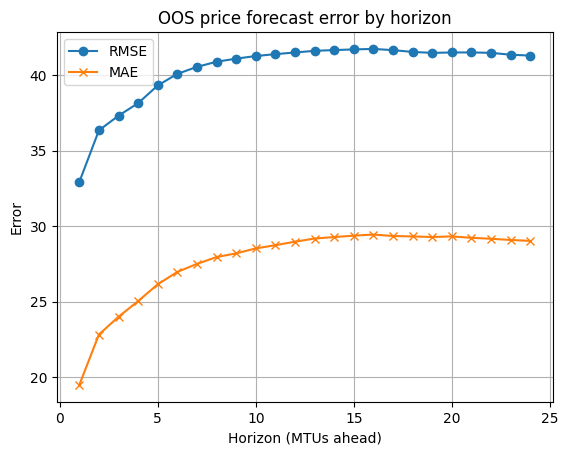

  horizon_range   mae_mean  rmse_mean
0           1-4  22.844420  36.189917
1          5-12  27.883270  40.768648
2         13-24  29.261213  41.550546


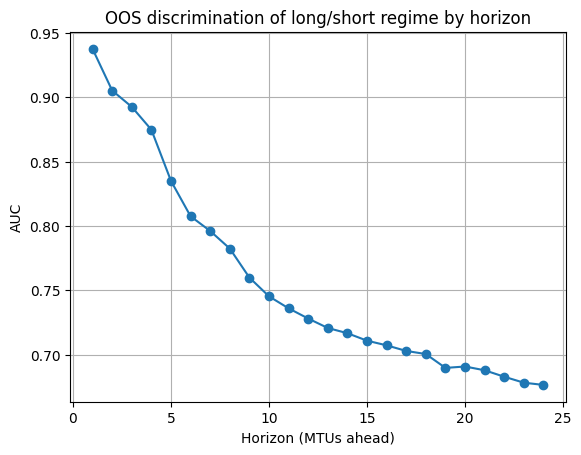

  horizon_range  auc_mean  brier_mean  log_loss_mean
0           1-4  0.902688    0.117151       0.367170
1          5-12  0.773908    0.178734       0.534127
2         13-24  0.697162    0.203494       0.593917


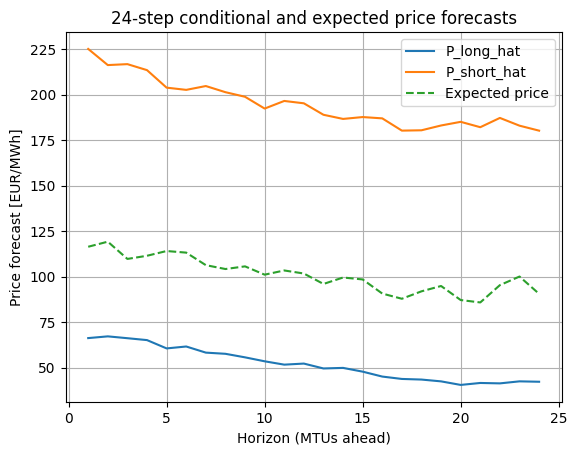

In [ ]:
regression_results(price_metrics, prob_metrics, forecasts)

## Cross Validation for best penalties

In [ ]:
from sklearn.model_selection import TimeSeriesSplit


def regression_cv(
    df_features: pd.DataFrame,
    alphas,
    r_type: str = "ridge",
    horizons=range(1, 25),
    n_splits: int = 3,
) -> tuple[float, pd.DataFrame, pd.DataFrame]:
    """
    Perform time-series cross-validation to select the Ridge alpha
    hyperparameter for the price models.

    For each alpha and each fold:
      - train Ridge-based models on the training slice using
        `train_models_from_features` with reg_type="ridge",
      - evaluate OOS price RMSE on the validation slice using
        `evaluate_models_from_features`,
      - aggregate the mean RMSE across horizons.

    Parameters
    ----------
    df_features : pd.DataFrame
        Full feature DataFrame (output of build_all_features, with NaNs
        already dropped).
    alphas : iterable of float
        Candidate alpha values for Ridge regularization.
    r_type : str
        Type of regression model to use ("ridge" or "lasso").
    horizons : iterable of int
        Horizons to train and evaluate (default: 1..24).
    n_splits : int
        Number of time-based CV splits (TimeSeriesSplit).

    Returns
    -------
    best_alpha : float
        Alpha value with lowest average RMSE across folds.
    cv_results : pd.DataFrame
        Per-fold results with columns:
        ["alpha", "fold", "mean_rmse", "n_horizons"].
    summary : pd.DataFrame
        Aggregated results per alpha, sorted by mean_rmse ascending.
    """
    # Ensure sorted by time
    df = df_features.sort_values("reference_date").reset_index(drop=True)

    tscv = TimeSeriesSplit(n_splits=n_splits)

    records = []

    for alpha in alphas:
        fold_id = 0
        for train_idx, val_idx in tscv.split(df):
            df_train = df.iloc[train_idx].copy()
            df_val = df.iloc[val_idx].copy()

            # Train Ridge models on this fold
            models = train_regression_models(
                df=df_train,
                horizons=horizons,
                reg_type=r_type,
                reg_alpha=alpha,
            )

            # OOS evaluation on validation slice (only price metrics are needed here)
            price_metrics, _ = evaluate_models_from_features(
                df=df_val,
                models=models,
                horizons=horizons,
            )

            if price_metrics.empty:
                continue

            mean_rmse = price_metrics["rmse"].mean()

            records.append(
                {
                    "alpha": alpha,
                    "fold": fold_id,
                    "mean_rmse": mean_rmse,
                    "n_horizons": len(price_metrics),
                }
            )

            fold_id += 1

    cv_results = pd.DataFrame(records)

    if cv_results.empty:
        raise ValueError("CV produced no results. Check that df_features is not too short.")

    # Aggregate over folds: mean RMSE per alpha
    summary = (
        cv_results
        .groupby("alpha", as_index=False)["mean_rmse"]
        .mean()
        .sort_values("mean_rmse")
        .reset_index(drop=True)
    )

    best_alpha = float(summary.iloc[0]["alpha"])
    return best_alpha, cv_results, summary


In [ ]:
alphas = np.logspace(3, 5, 4)
test_h = [1,3,5,12,24]
ridge_alpha, ridge_cv, ridge_cv_summary = regression_cv(
    df_features=features_df,
    alphas=alphas,
    r_type="ridge",
    horizons=test_h,
    n_splits=3,
)

Best alpha Ridge 10000 37.77

In [ ]:
print(ridge_cv_summary)

           alpha  mean_rmse
0   21544.346900  37.854656
1  100000.000000  37.957142
2    4641.588834  38.249790
3    1000.000000  38.700979


In [ ]:
lasso_alpha, lasso_cv, lasso_cv_summary = regression_cv(
    df_features=features_df,
    alphas=alphas,
    r_type="lasso",
    horizons=test_h,
    n_splits=3,
)
print("Laasso CV summary:")
print(lasso_cv_summary)

Laasso CV summary:
           alpha  mean_rmse
0    1000.000000  43.745708
1    4641.588834  44.104653
2   21544.346900  44.304309
3  100000.000000  44.586042


Best alpha Lasso 1000 43.?

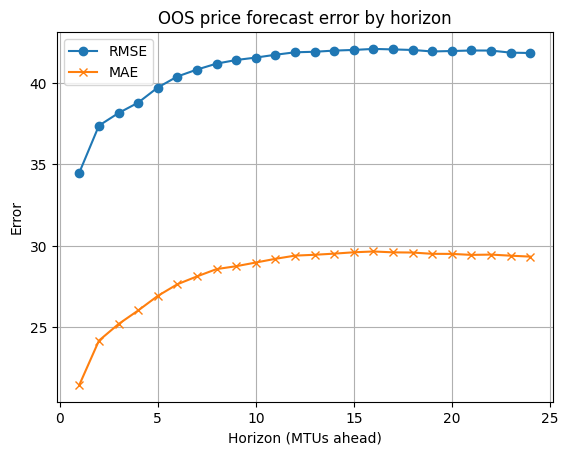

  horizon_range   mae_mean  rmse_mean
0           1-4  24.220782  37.201189
1          5-12  28.449036  41.081423
2         13-24  29.506224  41.966322


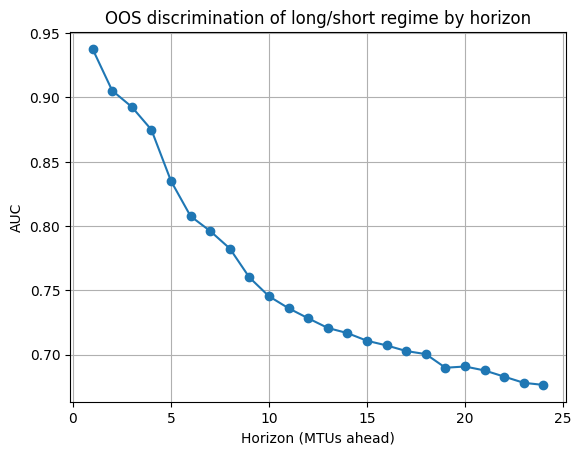

  horizon_range  auc_mean  brier_mean  log_loss_mean
0           1-4  0.902680    0.117152       0.367171
1          5-12  0.773944    0.178722       0.534096
2         13-24  0.697125    0.203497       0.593926


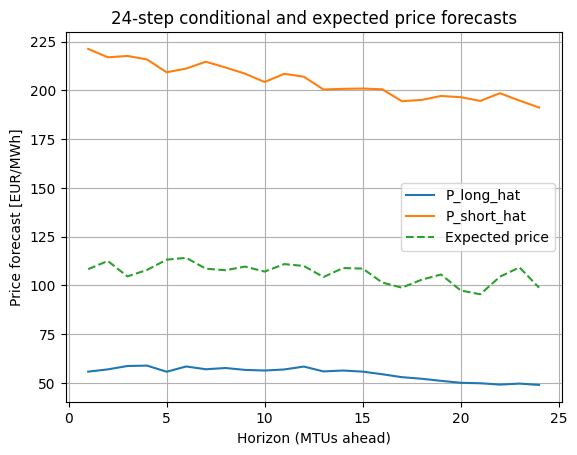

In [ ]:
models = train_regression_models(
    df=df_train,
    horizons=range(1, 25),
    reg_type="ridge",    
    reg_alpha=ridge_alpha,
)

price_metrics_ridge, prob_metrics_ridge = evaluate_models_from_features(
    df=df_valid,
    models=models,
    horizons=range(1, 25),
)

forecasts_ridge = predict_24_steps_from_features(
    df_recent=df_valid,
    models=models,
)

regression_results(price_metrics_ridge, prob_metrics_ridge, forecasts_ridge)

In [ ]:
models = train_regression_models(
    df=df_train,
    horizons=range(1, 25),
    reg_type="lasso",    
    reg_alpha=lasso_alpha,
)

price_metrics_lasso, prob_metrics_lasso = evaluate_models_from_features(
    df=df_valid,
    models=models,
    horizons=range(1, 25),
)

forecasts_lasso = predict_24_steps_from_features(
    df_recent=df_valid,
    models=models,
)

regression_results(price_metrics_lasso, prob_metrics_lasso, forecasts_lasso)

KeyboardInterrupt: 

## XGBoost


In [ ]:
from xgboost import XGBRegressor, XGBClassifier


def train_xgb_two_stage_residual_models(
    df: pd.DataFrame,
    horizons=range(1, 25),
    save_dir: str | None = None,
    xgb_reg_params: dict | None = None,
    xgb_clf_params: dict | None = None,
) -> dict:
    """
    Two-stage XGBoost training for imbalance forecasting with residual prices.

    Stage 1 (per horizon):
        Train an XGBRegressor to forecast quantity at horizon h.

    Stage 2 (per horizon):
        Use the in-sample predicted quantity as an additional feature
        to train:
            - conditional price *residual* models for P_long and P_short:
                r_long = P_long_target - current_price
                r_short = P_short_target - current_price
            - a probability model for the long regime (XGBClassifier).

    At prediction time, price forecasts are reconstructed as:
        P_hat = current_price_last + r_hat

    Parameters
    ----------
    df : pd.DataFrame
        Feature DataFrame as returned by `build_all_features`, with no NaNs
        in the feature columns.
        It must contain columns "price", "quantity", "is_long".
    horizons : iterable of int
        Forecast horizons in MTUs ahead for which models are trained.
    save_dir : str or None
        If not None, directory where the full `models` dict will be serialized
        with joblib.
    xgb_reg_params : dict or None
        Parameters for XGBRegressor. If None, a reasonable default is used.
    xgb_clf_params : dict or None
        Parameters for XGBClassifier. If None, a reasonable default is used.

    Returns
    -------
    dict
        A dictionary containing:
        - "feature_cols": list of base feature column names
        - "horizons": list of horizons
        - "quantity": dict[h] -> XGBRegressor for Q at horizon h
        - "price_long_resid": dict[h] -> XGBRegressor for r_long at horizon h
        - "price_short_resid": dict[h] -> XGBRegressor for r_short at horizon h
        - "prob_long": dict[h] -> XGBClassifier or DummyClassifier for P(Y_long=1)
        - "model_type": "xgboost_two_stage_residual"
        - "xgb_reg_params": dict of regressor hyperparameters
        - "xgb_clf_params": dict of classifier hyperparameters
        - "uses_quantity_hat": True
    """
    # Ensure sorted by reference_date
    df = df.sort_values("reference_date").reset_index(drop=True)

    # Default hyperparameters for XGBRegressor
    if xgb_reg_params is None:
        xgb_reg_params = {
            "n_estimators": 300,
            "max_depth": 5,
            "learning_rate": 0.05,
            "subsample": 0.8,
            "colsample_bytree": 0.8,
            "objective": "reg:squarederror",
            "tree_method": "hist",
            "n_jobs": -1,
        }

    # Default hyperparameters for XGBClassifier
    if xgb_clf_params is None:
        xgb_clf_params = {
            "n_estimators": 300,
            "max_depth": 4,
            "learning_rate": 0.05,
            "subsample": 0.8,
            "colsample_bytree": 0.8,
            "objective": "binary:logistic",
            "eval_metric": "logloss",
            "tree_method": "hist",
            "n_jobs": -1,
        }

    # Select base feature columns: numeric, not timestamps
    exclude_cols = {"flow_date", "mtu", "reference_date"}
    numeric_cols = df.select_dtypes(include=["number"]).columns
    feature_cols = [c for c in numeric_cols if c not in exclude_cols]

    models_price_long_resid: dict[int, object] = {}
    models_price_short_resid: dict[int, object] = {}
    models_quantity: dict[int, object] = {}
    models_prob_long: dict[int, object] = {}

    for h in horizons:
        # Horizon-specific targets
        price_target_col = f"price_target_h{h}"
        quantity_target_col = f"quantity_target_h{h}"
        is_long_target_col = f"is_long_target_h{h}"

        df[price_target_col] = df["price"].shift(-h)
        df[quantity_target_col] = df["quantity"].shift(-h)
        df[is_long_target_col] = df["is_long"].shift(-h)

        cols_for_valid = feature_cols + [
            price_target_col,
            quantity_target_col,
            is_long_target_col,
        ]
        valid_mask = df[cols_for_valid].notna().all(axis=1)
        tmp = df.loc[valid_mask].copy()

        if tmp.empty:
            raise ValueError(f"No valid samples for horizon {h} after shifting.")

        # Base features and current price at origin
        X_base = tmp[feature_cols].to_numpy()
        price_current = tmp["price"].to_numpy()
        y_price_target = tmp[price_target_col].to_numpy()
        y_quantity = tmp[quantity_target_col].to_numpy()
        y_regime = tmp[is_long_target_col].to_numpy().astype(int)

        # Residual targets for price
        y_price_resid = y_price_target - price_current

        # ---------------------- Stage 1: quantity model ----------------------
        model_quantity = XGBRegressor(**xgb_reg_params)
        model_quantity.fit(X_base, y_quantity)
        models_quantity[h] = model_quantity

        # Use in-sample quantity predictions as an additional feature
        q_hat_train = model_quantity.predict(X_base).reshape(-1, 1)
        X_enriched = np.hstack([X_base, q_hat_train])

        # ----------------- Stage 2: conditional price residual models --------
        mask_long = y_regime == 1
        mask_short = y_regime == 0

        X_long = X_enriched[mask_long]
        r_long = y_price_resid[mask_long]
        X_short = X_enriched[mask_short]
        r_short = y_price_resid[mask_short]

        if len(r_long) == 0 or len(r_short) == 0:
            raise ValueError(
                f"Not enough data for both regimes at horizon {h}: "
                f"long={len(r_long)}, short={len(r_short)}."
            )

        model_long_resid = XGBRegressor(**xgb_reg_params)
        model_short_resid = XGBRegressor(**xgb_reg_params)

        model_long_resid.fit(X_long, r_long)
        model_short_resid.fit(X_short, r_short)

        models_price_long_resid[h] = model_long_resid
        models_price_short_resid[h] = model_short_resid

        # ----------------- Stage 2: probability model (classifier) -----------
        unique_classes = np.unique(y_regime)
        if len(unique_classes) > 1:
            clf = XGBClassifier(**xgb_clf_params)
            clf.fit(X_enriched, y_regime)
        else:
            dummy = DummyClassifier(
                strategy="constant",
                constant=int(unique_classes[0]),
            )
            dummy.fit(X_enriched, y_regime)
            clf = dummy

        models_prob_long[h] = clf

    models = {
        "feature_cols": feature_cols,
        "horizons": list(horizons),
        "quantity": models_quantity,
        "price_long_resid": models_price_long_resid,
        "price_short_resid": models_price_short_resid,
        "prob_long": models_prob_long,
        "model_type": "xgboost_two_stage_residual",
        "xgb_reg_params": xgb_reg_params,
        "xgb_clf_params": xgb_clf_params,
        "uses_quantity_hat": True,
        "uses_price_residual": True,
    }

    if save_dir is not None:
        save_path = Path(save_dir)
        save_path.mkdir(parents=True, exist_ok=True)
        joblib.dump(models, save_path / "models_xgb_two_stage_residual.joblib")

    return models

In [ ]:
models_xgb = train_xgb_two_stage_residual_models(
    df=df_train,
    horizons=range(1, 25),
)

price_metrics_xgb, prob_metrics_xgb = evaluate_models_from_features(
    df=df_valid,
    models=models_xgb,
    horizons=range(1, 25),
)

forecasts_xgb = predict_24_steps_from_features_residual(
    df_recent=df_valid,
    models=models_xgb,
)


KeyError: "['price_target_h1', 'quantity_target_h1', 'is_long_target_h1', 'price_target_h2', 'quantity_target_h2', 'is_long_target_h2', 'price_target_h3', 'quantity_target_h3', 'is_long_target_h3', 'price_target_h4', 'quantity_target_h4', 'is_long_target_h4', 'price_target_h5', 'quantity_target_h5', 'is_long_target_h5', 'price_target_h6', 'quantity_target_h6', 'is_long_target_h6', 'price_target_h7', 'quantity_target_h7', 'is_long_target_h7', 'price_target_h8', 'quantity_target_h8', 'is_long_target_h8', 'price_target_h9', 'quantity_target_h9', 'is_long_target_h9', 'price_target_h10', 'quantity_target_h10', 'is_long_target_h10', 'price_target_h11', 'quantity_target_h11', 'is_long_target_h11', 'price_target_h12', 'quantity_target_h12', 'is_long_target_h12', 'price_target_h13', 'quantity_target_h13', 'is_long_target_h13', 'price_target_h14', 'quantity_target_h14', 'is_long_target_h14', 'price_target_h15', 'quantity_target_h15', 'is_long_target_h15', 'price_target_h16', 'quantity_target_h16', 'is_long_target_h16', 'price_target_h17', 'quantity_target_h17', 'is_long_target_h17', 'price_target_h18', 'quantity_target_h18', 'is_long_target_h18', 'price_target_h19', 'quantity_target_h19', 'is_long_target_h19', 'price_target_h20', 'quantity_target_h20', 'is_long_target_h20', 'price_target_h21', 'quantity_target_h21', 'is_long_target_h21', 'price_target_h22', 'quantity_target_h22', 'is_long_target_h22', 'price_target_h23', 'quantity_target_h23', 'is_long_target_h23', 'price_target_h24', 'quantity_target_h24', 'is_long_target_h24'] not in index"

In [ ]:
forecasts_xgb = predict_24_steps_from_features_residual(
    df_recent=df_valid,
    models=models_xgb,
)

KeyError: ['price_target_h1', 'quantity_target_h1', 'is_long_target_h1', 'price_target_h2', 'quantity_target_h2', 'is_long_target_h2', 'price_target_h3', 'quantity_target_h3', 'is_long_target_h3', 'price_target_h4', 'quantity_target_h4', 'is_long_target_h4', 'price_target_h5', 'quantity_target_h5', 'is_long_target_h5', 'price_target_h6', 'quantity_target_h6', 'is_long_target_h6', 'price_target_h7', 'quantity_target_h7', 'is_long_target_h7', 'price_target_h8', 'quantity_target_h8', 'is_long_target_h8', 'price_target_h9', 'quantity_target_h9', 'is_long_target_h9', 'price_target_h10', 'quantity_target_h10', 'is_long_target_h10', 'price_target_h11', 'quantity_target_h11', 'is_long_target_h11', 'price_target_h12', 'quantity_target_h12', 'is_long_target_h12', 'price_target_h13', 'quantity_target_h13', 'is_long_target_h13', 'price_target_h14', 'quantity_target_h14', 'is_long_target_h14', 'price_target_h15', 'quantity_target_h15', 'is_long_target_h15', 'price_target_h16', 'quantity_target_h16', 'is_long_target_h16', 'price_target_h17', 'quantity_target_h17', 'is_long_target_h17', 'price_target_h18', 'quantity_target_h18', 'is_long_target_h18', 'price_target_h19', 'quantity_target_h19', 'is_long_target_h19', 'price_target_h20', 'quantity_target_h20', 'is_long_target_h20', 'price_target_h21', 'quantity_target_h21', 'is_long_target_h21', 'price_target_h22', 'quantity_target_h22', 'is_long_target_h22', 'price_target_h23', 'quantity_target_h23', 'is_long_target_h23', 'price_target_h24', 'quantity_target_h24', 'is_long_target_h24']

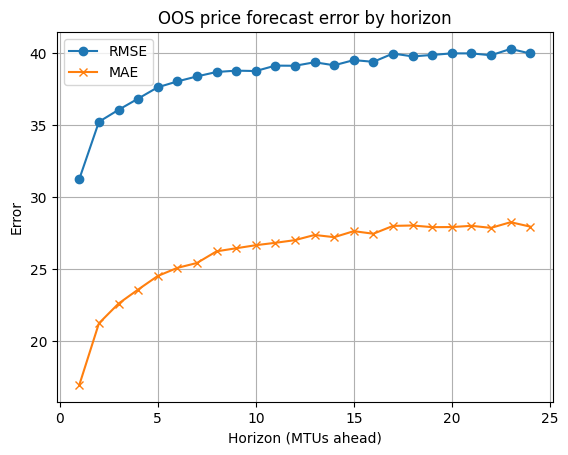

  horizon_range   mae_mean  rmse_mean
0           1-4  21.108626  34.847316
1          5-12  26.035363  38.561276
2         13-24  27.808705  39.754827


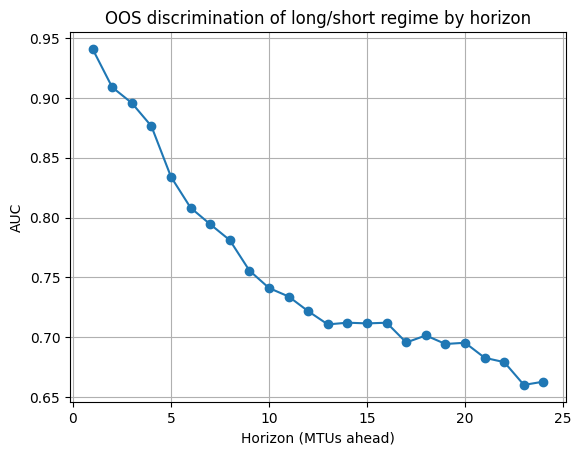

  horizon_range  auc_mean  brier_mean  log_loss_mean
0           1-4  0.905464    0.115498       0.360087
1          5-12  0.771359    0.178692       0.530360
2         13-24  0.693329    0.204296       0.598570


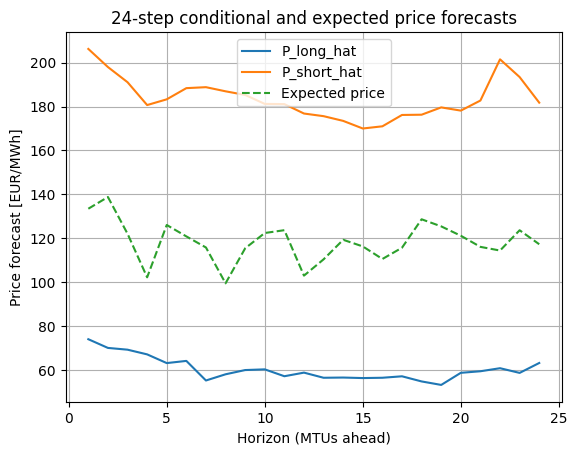

In [ ]:
regression_results(price_metrics_xgb, prob_metrics_xgb, forecasts_xgb)

In [ ]:
forecasts_xgb

,horizon,quantity_hat,P_long_hat,P_short_hat,pi_long_hat,E_price_hat
0,1,18.809076,74.007805,206.248367,0.550475,133.453244
1,2,23.790260,70.044861,197.989426,0.462682,138.791842
2,3,15.590224,69.241356,191.083069,0.566565,122.051792
3,4,23.271967,67.104317,180.677109,0.690934,102.205825
4,5,6.163180,63.136303,183.287384,0.476404,126.046931
5,6,14.251991,64.130127,188.380600,0.543535,120.846105
6,7,8.364183,55.205746,188.821594,0.546521,115.797678
7,8,21.992239,58.030895,186.938446,0.678499,99.474750
8,9,8.464336,59.962944,185.286530,0.557467,115.422709
9,10,6.356208,60.276978,181.203369,0.486328,122.393503


In [ ]:
#give me a function to find the best set of parameters for XGBoost. Use any library you want
from sklearn.model_selection import GridSearchCV

def xgb_hyperparameter_tuning(
    df: pd.DataFrame,
    horizons=range(1, 25),
    param_grid: dict | None = None,
    n_splits: int = 3,
) -> dict:
    """
    Perform hyperparameter tuning for XGBoost models using GridSearchCV.

    Parameters
    ----------
    df : pd.DataFrame
        Feature DataFrame as returned by `build_all_features`, with no NaNs
        in the feature columns.
    horizons : iterable of int
        Forecast horizons in MTUs ahead for which models are trained.
    param_grid : dict or None
        Grid of hyperparameters to search. If None, a default grid is used.
    n_splits : int
        Number of time-based CV splits (TimeSeriesSplit).

    Returns
    -------
    dict
        Best hyperparameters found for XGBRegressor and XGBClassifier.
    """
    if param_grid is None:
        param_grid = {
            'n_estimators': [100, 200],
            'max_depth': [3, 5],
            'learning_rate': [0.01, 0.1],
            'subsample': [0.8, 1.0],
            'colsample_bytree': [0.8, 1.0],
        }

    # Ensure sorted by reference_date

    tscv = TimeSeriesSplit(n_splits=n_splits)

    best_params = {}

    for h in horizons:
        # Horizon-specific targets
        quantity_target_col = f"quantity_target_h{h}"
        is_long_target_col = f"is_long_target_h{h}"

        df[quantity_target_col] = df["quantity"].shift(-h)
        df[is_long_target_col] = df["is_long"].shift(-h)

        cols_for_valid = ['price', 'quantity'] + [quantity_target_col, is_long_target_col]
        valid_mask = df[cols_for_valid].notna().all(axis=1)
        tmp = df.loc[valid_mask].copy()

        if tmp.empty:
            continue

        X_base = tmp.drop(columns=cols_for_valid).to_numpy()
        y_quantity = tmp[quantity_target_col].to_numpy()
        y_regime = tmp[is_long_target_col].to_numpy().astype(int)

        # Quantity model tuning
        xgb_reg = XGBRegressor(objective="reg:squarederror", tree_method="hist", n_jobs=-1)
        grid_search_reg = GridSearchCV(
            estimator=xgb_reg,
            param_grid=param_grid,
            cv=tscv,
            scoring='neg_mean_squared_error',
            n_jobs=-1,
        )
        grid_search_reg.fit(X_base, y_quantity)
        best_params[f"quantity_h{h}"] = grid_search_reg.best_params_

        # Probability model tuning
        xgb_clf = XGBClassifier(objective="binary:logistic", tree_method="hist", n_jobs=-1)
        grid_search_clf = GridSearchCV(
            estimator=xgb_clf,
            param_grid=param_grid,
            cv=tscv,
            scoring='roc_auc',
            n_jobs=-1,
        )
        grid_search_clf.fit(X_base, y_regime)
        best_params[f"prob_long_h{h}"] = grid_search_clf.best_params
    return best_params


In [ ]:
# I want to find best parameters for XGB two-stage residual models using a subset of horizons
best_xgb_params = xgb_hyperparameter_tuning(
    df=features_df,
    horizons=[1, 12, 24],
)

ValueError: 
All the 96 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
96 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\calan\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\calan\Desktop\MA3\Financial_Big_Data\myenv\Lib\site-packages\xgboost\core.py", line 774, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\calan\Desktop\MA3\Financial_Big_Data\myenv\Lib\site-packages\xgboost\sklearn.py", line 1343, in fit
    train_dmatrix, evals = _wrap_evaluation_matrices(
                           ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\calan\Desktop\MA3\Financial_Big_Data\myenv\Lib\site-packages\xgboost\sklearn.py", line 702, in _wrap_evaluation_matrices
    train_dmatrix = create_dmatrix(
                    ^^^^^^^^^^^^^^^
  File "c:\Users\calan\Desktop\MA3\Financial_Big_Data\myenv\Lib\site-packages\xgboost\sklearn.py", line 1262, in _create_dmatrix
    return DMatrix(**kwargs, nthread=self.n_jobs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\calan\Desktop\MA3\Financial_Big_Data\myenv\Lib\site-packages\xgboost\core.py", line 774, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\calan\Desktop\MA3\Financial_Big_Data\myenv\Lib\site-packages\xgboost\core.py", line 999, in __init__
    handle, feature_names, feature_types = dispatch_data_backend(
                                           ^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\calan\Desktop\MA3\Financial_Big_Data\myenv\Lib\site-packages\xgboost\data.py", line 1357, in dispatch_data_backend
    return _from_numpy_array(
           ^^^^^^^^^^^^^^^^^^
  File "c:\Users\calan\Desktop\MA3\Financial_Big_Data\myenv\Lib\site-packages\xgboost\data.py", line 285, in _from_numpy_array
    data, _ = _ensure_np_dtype(data, data.dtype)
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\calan\Desktop\MA3\Financial_Big_Data\myenv\Lib\site-packages\xgboost\_data_utils.py", line 384, in _ensure_np_dtype
    data = data.astype(dtype, copy=False)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: float() argument must be a string or a real number, not 'Timestamp'
